<a href="https://colab.research.google.com/github/mathispernin/DeepLearningInPracticeMVA/blob/Yani/TP3(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 3  : Graph Neural Networks Architecture

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**). Make sure you are using the GPU : Edit --> Notebook Setting --> Hardware accelerator --> GPU
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


In [3]:
cd TP3_DLP/

/content/drive/MyDrive/TP3_DLP


In [4]:
ls

 class_model_gnn.py   message_passing.py   processed/   raw/  'TP3(1).ipynb'


In [5]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 # downgrade pytorch
!pip install torch-geometric pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.5.0+cu121.html

Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu121.html
  Using cached torch_geometric-2.7.0-py3-none-any.whl.metadata (63 kB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu121/pyg_lib-0.4.0%2Bpt25cu121-cp312-cp312-linux_x86_64.whl (2.5 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu121/torch_scatter-2.1.2%2Bpt25cu121-cp312-cp312-linux_x86_64.whl (10.9 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu121/torch_sparse-0.6.18%2Bpt25cu121-cp312-cp312-linux_x86_64.whl (5.1 MB)
  Using cached https://data.pyg.org/whl/torch-2.5.0%2Bcu121/torch_cluster-1.6.3%2Bpt25cu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
Using cached torch_geometric-2.7.0-py3-none-any.whl (1.3 MB)


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

In [6]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node).

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [7]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [8]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [9]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [10]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Let's train this model !

In [ ]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(
    device
)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda
Epoch 00001 | Loss: 0.6371
F1-Score: 0.4560
Epoch 00002 | Loss: 0.5810
Epoch 00003 | Loss: 0.5622
Epoch 00004 | Loss: 0.5557
Epoch 00005 | Loss: 0.5506
Epoch 00006 | Loss: 0.5461
F1-Score: 0.5003
Epoch 00007 | Loss: 0.5417
Epoch 00008 | Loss: 0.5371
Epoch 00009 | Loss: 0.5337
Epoch 00010 | Loss: 0.5311
Epoch 00011 | Loss: 0.5285
F1-Score: 0.5291
Epoch 00012 | Loss: 0.5260
Epoch 00013 | Loss: 0.5237
Epoch 00014 | Loss: 0.5215
Epoch 00015 | Loss: 0.5192
Epoch 00016 | Loss: 0.5169
F1-Score: 0.5072
Epoch 00017 | Loss: 0.5145
Epoch 00018 | Loss: 0.5121
Epoch 00019 | Loss: 0.5094
Epoch 00020 | Loss: 0.5072
Epoch 00021 | Loss: 0.5054
F1-Score: 0.5380
Epoch 00022 | Loss: 0.5034
Epoch 00023 | Loss: 0.5014
Epoch 00024 | Loss: 0.4996
Epoch 00025 | Loss: 0.4978
Epoch 00026 | Loss: 0.4959
F1-Score: 0.5470
Epoch 00027 | Loss: 0.4940
Epoch 00028 | Loss: 0.4923
Epoch 00029 | Loss: 0.4909
Epoch 00030 | Loss: 0.4895
Epoch 00031 | Loss: 0.4878
F1-Score: 0.5375
Epoch 00032 | Loss: 0.4862
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6508


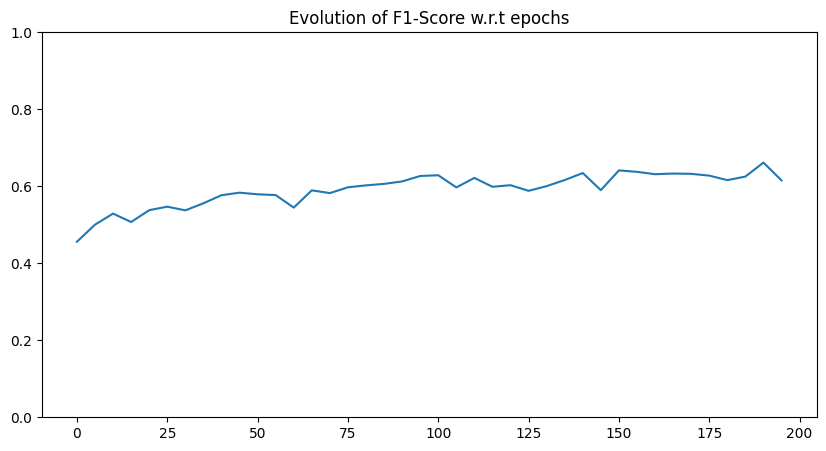

In [ ]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files :
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights

 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.

Intermediate question :

 Provide the script for training, and a plot of the training loss.  

In [11]:
import torch
import torch.nn as nn
import torch_geometric.nn as graphnn

class StudentModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, heads=4):
        super(StudentModel, self).__init__()

        # TransformerConv supports multi-head attention
        # output dim of first layer = hidden_size * heads
        self.conv1 = graphnn.TransformerConv(input_size, hidden_size, heads=heads)

        # Second layer: input must match previous output dim
        self.conv2 = graphnn.TransformerConv(hidden_size * heads, hidden_size, heads=heads)

        # Third layer: project to output size (concat=False to average heads at the end)
        self.conv3 = graphnn.TransformerConv(hidden_size * heads, output_size, heads=1, concat=False)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.elu(x)

        x = self.conv2(x, edge_index)
        x = self.elu(x)

        x = self.conv3(x, edge_index)
        return x

In [13]:
def train_and_track(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []
    loss_history = [] # Tracking loss for plotting

    for epoch in range(max_epochs):
        model.train()
        losses = []
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch = train_batch.to(device)

            logits = model(train_batch.x, train_batch.edge_index)
            loss = loss_fcn(logits, train_batch.y)

            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        avg_loss = np.mean(losses)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            score = evaluate(model, device, val_dataloader)
            print(f"Epoch {epoch+1:03d} | Loss: {avg_loss:.4f} | Val F1: {score:.4f}")
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list, loss_history

# --- Execution ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Initialize the Transformer model

transformer_model = StudentModel(input_size=n_features, hidden_size=64, output_size=n_classes).to(device)

optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
loss_fcn = nn.BCEWithLogitsLoss()

# Start Training
epochs, val_scores, loss_history = train_and_track(
    transformer_model, loss_fcn, device, optimizer, 100, train_dataloader, val_dataloader
)


Device:  cuda
Epoch 001 | Loss: 0.6079 | Val F1: 0.3987
Epoch 010 | Loss: 0.4103 | Val F1: 0.6481
Epoch 020 | Loss: 0.2837 | Val F1: 0.7729
Epoch 030 | Loss: 0.2152 | Val F1: 0.8296
Epoch 040 | Loss: 0.1703 | Val F1: 0.8638
Epoch 050 | Loss: 0.1357 | Val F1: 0.8932
Epoch 060 | Loss: 0.1120 | Val F1: 0.9104
Epoch 070 | Loss: 0.0956 | Val F1: 0.9219
Epoch 080 | Loss: 0.0819 | Val F1: 0.9315
Epoch 090 | Loss: 0.0728 | Val F1: 0.9369
Epoch 100 | Loss: 0.0663 | Val F1: 0.9414


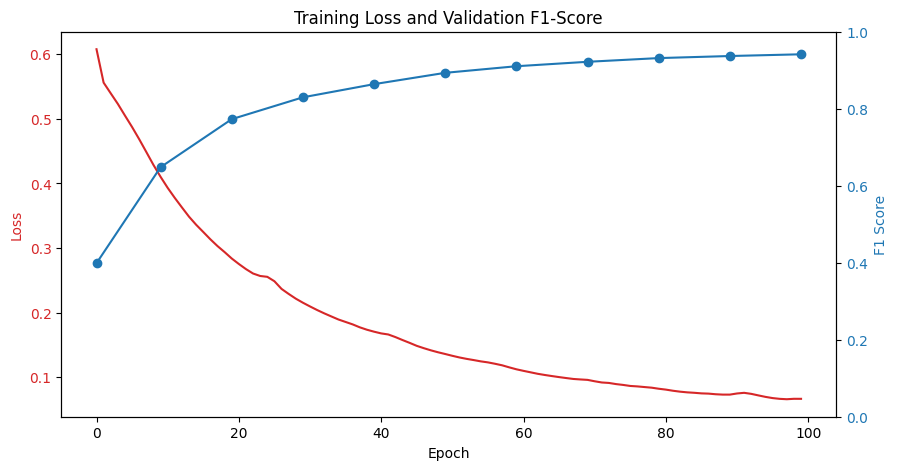

In [14]:
def plot_training_results(loss_history, val_epochs, val_scores):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Loss
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(loss_history, color='tab:red', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Plot F1 Score on a second y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('F1 Score', color='tab:blue')
    ax2.plot(val_epochs, val_scores, color='tab:blue', marker='o', label='Val F1 Score')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim([0, 1])

    plt.title("Training Loss and Validation F1-Score")
    plt.show()

plot_training_results(loss_history, epochs, val_scores)

In [15]:
# Define the path where you want to save it
MODEL_PATH = "graph_transformer_ppi.pth"

# Save the state_dict
torch.save(transformer_model.state_dict(), MODEL_PATH)

print(f"Model saved successfully to {MODEL_PATH}")

Model saved successfully to graph_transformer_ppi.pth


## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 5x5 kernel with stride 1 and padding 2.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)

$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ :

$$ \gamma_\Theta : x,y \mapsto y $$


In [ ]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [ ]:
def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.
    COMPLETE

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None
        Is used to determine the size of the receptive field.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    # Assumptions (remove it for the bonus)
    assert image.dim() == 3, f"Expected 3D tensor, got {image.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 2, "Expected padding of 2 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 5, "Expected kernel size of 5x5."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    raise NotImplementedError

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [ ]:
def graph_to_image(
    data: torch.Tensor, height: int, width: int, conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image.
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    # Assumptions (remove it for the bonus)
    assert data.dim() == 2, f"Expected 2D tensor, got {data.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 2, "Expected padding of 2 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 5, "Expected kernel size of 5x5."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    raise NotImplementedError

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [ ]:
ref_conv = torch.nn.Conv2d(5, 7, kernel_size=5, padding=2, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism.
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [ ]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        # <TO IMPLEMENT>
        # Don't forget to call the parent constructor with the correct aguments
        # super().__init__(<arguments>)
        # </TO IMPLEMENT>
        raise NotImplementedError

    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message trough the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size COMPLETE)
        """
        raise NotImplementedError


## Test example

In [ ]:
from message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=5, padding=2, stride=1, bias=False)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)
